In [12]:
import gymnasium as gym
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
env_id = "CartPole-v1"

num_envs = 1

total_timesteps = 100_000

learning_rate = 1e-3

gamma = 0.99

eps = 0.1

seed = None


In [14]:
video_path = "qlearning_cartpole_videos"

In [15]:
def make_env(env_id, capture_video, seed=None) :
  if capture_video:
    env = gym.make(env_id, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env, video_path, episode_trigger=lambda episode: True)
  else:
    env = gym.make(env_id)
  env = gym.wrappers.RecordEpisodeStatistics(env)
  if seed is not None:
    env.action_space.seed(seed)
  return env

In [16]:
class QNetwork(nn.Module):
  def __init__(self, envs, n_hidden=128):
    super().__init__()
    self.network = nn.Sequential(
      nn.Linear(np.array(envs.single_observation_space.shape) .prod(), n_hidden),
      nn.ReLU() ,
      nn.Linear(n_hidden, envs.single_action_space.n))

  def forward(self, x):
    return self.network(x)

In [17]:
# make environments
envs = gym.vector.SyncVectorEnv([
  lambda: make_env
    (env_id,
    capture_video=False,
    seed=seed if seed is None else seed + i)
  for i in range (num_envs)
])

In [18]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu"
)

In [19]:
q_network = QNetwork(envs).to(device)
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)


In [20]:
def np2torch(a):
  return torch.as_tensor(a, dtype = torch.float32, device = device)

In [22]:
import torch

# Convert observations to tensor
obs_tensor = torch.tensor(obs, dtype=torch.float32)

# Forward pass to get Q-values
with torch.no_grad():
    q_values = q_network(obs_tensor)
    actions = q_values.argmax(dim=1).cpu().numpy()


In [24]:
obs, _ = envs.reset(seed=seed)  # Proper reset

obs, rewards, dones, truncateds, infos = envs.step(actions)



In [25]:
#training loop
episode_returns = []
losses = []
start_time  = time.time()
obs, _ = envs.reset(seed=seed)
autoreset = np.zeros(num_envs, dtype=bool)
mask = np.logical_not(autoreset)
dones_ = dones[mask] | truncateds[mask]
rewards_ = rewards[mask]
obs_ = obs[mask]


In [26]:
import numpy as np
import torch
import torch.nn.functional as F
import time
import random

# Utility to safely convert observations to torch tensor
def np2torch(a):
    if isinstance(a, list):
        a = np.array(a)
    return torch.as_tensor(a, dtype=torch.float32, device=device)

# Hyperparameters
total_timesteps = 50_000
gamma = 0.99
eps = 0.1
learning_rate = 1e-3

# Initialize environment and variables
obs = envs.reset()
if isinstance(obs, tuple):
    obs = obs[0]  # unpack (obs, info) if returned
obs = np2torch(obs)

rets = np.zeros(num_envs)
episode_returns = []
losses = []
autoreset = np.zeros(num_envs, dtype=bool)
start_time = time.time()

for global_step in range(total_timesteps):

    # Epsilon-greedy action selection
    if random.random() < eps:
        actions = np.array([envs.single_action_space.sample() for _ in range(num_envs)])
    else:
        with torch.no_grad():
            q_values = q_network(obs)
        actions = torch.argmax(q_values, dim=1).cpu().numpy()

    # Step the environment
    next_obs, rewards, dones, truncateds, infos = envs.step(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    truncateds = np.array(truncateds)

    rets += rewards

    # Handle episode ends
    for i, (done, truncated) in enumerate(zip(dones, truncateds)):
        if done or truncated:
            episode_returns.append(rets[i])
            print(f"global_step={global_step}, episode={len(episode_returns)}, episode_return={rets[i]}")
            rets[i] = 0  # reset episode return for that env

    # Mask for active environments only
    mask = np.logical_not(dones | truncateds)

    if np.any(mask):
        obs_ = obs[mask]
        actions_ = actions[mask]
        next_obs_ = next_obs[mask]
        rewards_ = rewards[mask]
        dones_ = dones[mask]

        # Calculate TD target
        with torch.no_grad():
            q_next = q_network(np2torch(next_obs_)).max(dim=1).values
            td_target = np2torch(rewards_) + gamma * (1 - np2torch(dones_.astype(np.float32))) * q_next

        pred = q_network(np2torch(obs_)).gather(1, torch.tensor(actions_.reshape(-1, 1)).to(device))

        loss = F.mse_loss(td_target.unsqueeze(1), pred)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update obs and autoreset for next step
    if isinstance(next_obs, tuple):
        next_obs = next_obs[0]
    obs = np2torch(next_obs)
    autoreset = dones | truncateds

    # Logging
    if global_step % 1000 == 0 and global_step > 0:
        print("steps per second:", int(global_step / (time.time() - start_time)))

    # Early stopping condition (solved)
    if len(episode_returns) > 10 and np.all(np.array(episode_returns[-10:]) >= 500):
        print("Max reward achieved consistently!")
        break


global_step=9, episode=1, episode_return=10.0
global_step=20, episode=2, episode_return=10.0
global_step=30, episode=3, episode_return=9.0
global_step=40, episode=4, episode_return=9.0
global_step=50, episode=5, episode_return=9.0
global_step=62, episode=6, episode_return=11.0
global_step=72, episode=7, episode_return=9.0
global_step=82, episode=8, episode_return=9.0
global_step=93, episode=9, episode_return=10.0
global_step=104, episode=10, episode_return=10.0
global_step=115, episode=11, episode_return=10.0
global_step=129, episode=12, episode_return=13.0
global_step=140, episode=13, episode_return=10.0
global_step=155, episode=14, episode_return=14.0
global_step=165, episode=15, episode_return=9.0
global_step=175, episode=16, episode_return=9.0
global_step=186, episode=17, episode_return=10.0
global_step=198, episode=18, episode_return=11.0
global_step=209, episode=19, episode_return=10.0
global_step=219, episode=20, episode_return=9.0
global_step=231, episode=21, episode_return=11.

In [27]:
envs.close()

In [30]:
def smooth(x, a = 0.1):
  y = [x[0]]
  for xi in x[1:]:
    yi = a * xi + (1-a) * y[-1]
    y.append(yi)
  return y

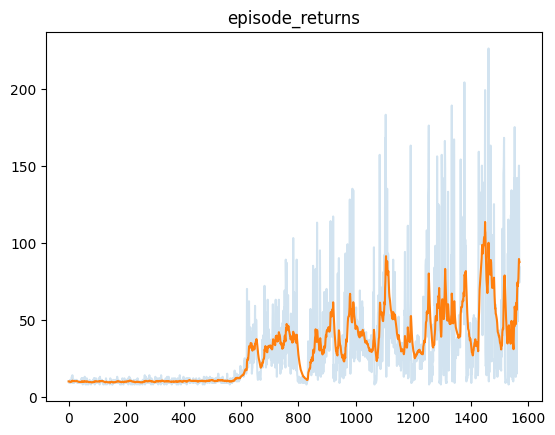

In [31]:
plt.plot(episode_returns, alpha = 0.2)
plt.plot(smooth(episode_returns))
plt.title("episode_returns");
plt.show();

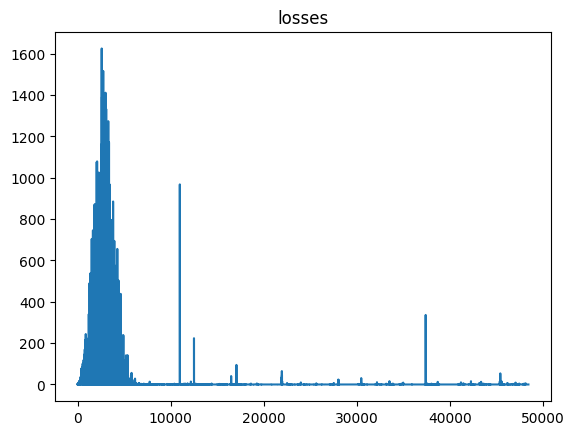

In [32]:
plt.plot(losses)
plt.title("losses");
plt.show();

In [35]:
model_path = "q_network.pth"
torch.save(q_network.state_dict(), "q_network.pth")

In [36]:
# load model for eval
envs_eval = gym.vector.SyncVectorEnv([lambda: make_env(env_id, True)])
model = QNetwork(envs_eval).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/qlearning_cartpole_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


QNetwork(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [38]:
n_episodes_eval = 10
eval_returns = np.zeros(n_episodes_eval)
obs, _ = envs_eval.reset()

for i in range(n_episodes_eval):
  episode_done = False
  while not episode_done:
    q_values = model(np2torch(obs))
    actions = torch.argmax(q_values, dim = 1).cpu().numpy()
    obs, rewards, dones, truncateds, infos = envs_eval.step(actions)
    if dones[0]  or truncateds[0]:
      G = infos["episode"]["r"][0]
      print(f"episode = {i}, return = {G}")
      eval_returns[i] = G
      episode_done = True

envs_eval.close()

episode = 0, return = 172.0
episode = 1, return = 154.0
episode = 2, return = 153.0
episode = 3, return = 152.0
episode = 4, return = 162.0
episode = 5, return = 158.0
episode = 6, return = 151.0
episode = 7, return = 162.0
episode = 8, return = 148.0
episode = 9, return = 157.0
